# Ερώτηση 3 (Clustering)

## Loading data

In [466]:
import pandas as pd
import numpy as np
import json
import time 

dataset_path = '../yelp-dataset/' # Change this path to match your local dataset folder path
leftK_path = '/home/left/Desktop/dataMining/set2/ask2/'
# path = leftK_path

business_filename = 'yelp_academic_dataset_business.json'
review_filename = 'yelp_academic_dataset_review.json'

# Reading business file
start = time.time()

list_business = []
categories_order = ['Beauty & Spas', 'Shopping', 'Bars']

with open(dataset_path + business_filename, 'r', encoding="utf8") as buisness_file:
    for line in buisness_file:
        json_dict = json.loads(line)
        if  json_dict['city'] == 'Toronto' and \
            json_dict['review_count'] >= 10 and \
            json_dict['categories'] is not None and \
            any(word in json_dict['categories'] for word in categories_order):
                # The following line makes sure that every buisness categoy is
                # set to one of the categories_order list in that specific order.
                temp_cat = [cat for cat in categories_order if cat in json_dict['categories']][0]
                list_business.append([json_dict['business_id'], temp_cat])

stop = time.time()
print("Read file in {:.3f} seconds".format(stop-start))

df_buisness = pd.DataFrame(list_business, columns=['business_id', 'categories'])
display(df_buisness.head())
print('{} businesses in df_buisness'.format(df_buisness['business_id'].size))

Read file in 2.189 seconds


,business_id,categories
0,cicPsia8Wj-DNRkmLbD_xg,Bars
1,xVXyrTWbG8U3szze-aA7eg,Bars
2,e-tRKAC-q40SqQfAOwYa-A,Beauty & Spas
3,TKKX9bllRBMzp0NYr441PQ,Bars
4,C9keC4mWuXdl2mYFHZXudQ,Shopping


3502 businesses in df_buisness


In [467]:
# Extracting unique buisness ids
np_businesses = np.array(list_business)
np_businesses_ids = np_businesses[:,0]
np_businesses_ids

array(['cicPsia8Wj-DNRkmLbD_xg', 'xVXyrTWbG8U3szze-aA7eg',
       'e-tRKAC-q40SqQfAOwYa-A', ..., 'AqpB2IoLkUupDCuH-hmVdg',
       'thzyiQZb16zD8wMliaEfRQ', '0hudPyuCBlKg79OwKBw-eQ'], dtype='<U22')

In [468]:
def find_buisness_index(business_id):
    index = np.where(np_businesses_ids == business_id)[0]
    return index

# Reading reveiws file
start = time.time()
business_reviews = [[] for i in range(int(len(np_businesses_ids)))]

with open(dataset_path + review_filename, 'r', encoding="utf8") as reviews_file:
    for line in reviews_file:
        json_dict = json.loads(line)
        index = find_buisness_index(json_dict['business_id'])
        if index.size > 0:
            if len(business_reviews[index[0]]) == 0:
               business_reviews[index[0]] = json_dict['text']
            else:
               business_reviews[index[0]] += json_dict['text']

stop = time.time()
print("Read file in {:.3f} mins".format((stop-start)/60))

Read file in 4.865 mins


Reading time: about 5 mins

In [469]:
df_business_reviews = pd.DataFrame(business_reviews, columns=['reviews as a single string for each buisness'])
df_business_reviews

,reviews as a single string for each buisness
0,"Consistently good, as the Keg tends to be.\n\n..."
1,I would give zero stars. I came here with a gr...
2,A blissful experience! I highly recommended th...
3,Mi'Hito is a new poke/sushi burrito chain that...
4,If you're a boy and you want to wear some hot ...
...,...
3497,This used to be my favourite place. It was alw...
3498,Very welcoming place. Great setup and super fr...
3499,I can't beleive I am saying this... but I left...
3500,I am really disappointed with this place. I t...


## TF-IDF

In [470]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text

# Load custom stopwords 
# source: https://github.com/kavgan/nlp-in-practice/blob/master/tf-idf/resources/stopwords.txt
with open('stopwords.txt', 'r') as text_file:
    lines = text_file.read().split('\n')

stop_words = text.ENGLISH_STOP_WORDS.union(lines)

# Allowing words that are alpharithmetics more than 2 chars, excluding
# common words that exist in more than max_df of docs and rare words that
# exist in less than min_df of docs.
tfidf = TfidfVectorizer(min_df=0.25,
                        max_df=0.85,
                        max_features=8000,
                        token_pattern=r'(?u)\b[A-Za-z][A-Za-z]+\b',
                        lowercase=True,
                        stop_words=stop_words)

document_term_matrix = tfidf.fit_transform(business_reviews)

In [471]:
import random 
samples_num = 30
print('Sample of words included in the features:\n{}\n\n'.format(random.sample(tfidf.get_feature_names(), samples_num)))
print('Sample of effective stop words list.:\n{}'.format(random.sample(tfidf.get_stop_words(), samples_num)))

Sample of words included in the features:
['offers', 'choice', 'glasses', 'ok', 'counter', 'decided', 'pass', 'terrible', 'hair', 'cooked', 'potato', 'room', 'management', 'truly', 'larger', 'cute', 'attention', 'heart', 'write', 'waiting', 'establishment', 'restaurants', 'situation', 'style', 'hand', 'help', 'working', 'odd', 'cheap', 'size']


Sample of effective stop words list.:
['plaintiff', 'wherever', 'm', 'whoso', 'through', 'amoungst', 'where', 'yet', 'e', 'inc', 'awfully', 'nothings', 'seemings', 'due', 'your', 'onest', 'not', 'bist', 'midsts', 'comeons', 'lotted', 'frae', 'outs', 'hereafters', 'sanserif', 'musts', 'own', 'meanwhiles', 'saider', 'excepts']


## Kmeans

In [487]:
from sklearn.cluster import KMeans
import sklearn.cluster as sk_cluster
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import silhouette_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('seaborn-paper')

# True values table: Μatching categories to numbers
true_labels = np_businesses[:,1]
for i in range(len(true_labels)):
    if true_labels[i]=='Bars':
        true_labels[i]=0
    if true_labels[i]=='Beauty & Spas':
        true_labels[i]=1
    if true_labels[i]=='Shopping':
        true_labels[i]=2
    
true_labels = [int(i) for i in true_labels] 
n0 = true_labels.count(0)
n1 = true_labels.count(1)
n2 = true_labels.count(2)
print('Bars: {}\nBeauty & Spas: {}\nShopping: {}\nSum: {}'.format(n0, n1, n2, n0+n1+n2))

def Kmeans_winfo(n_clusters, true_labels, data):
    kmeans = KMeans(init='k-means++', 
                    n_clusters=n_clusters, 
                    n_init=25, 
                    max_iter=600,  
                    random_state=42)

    predictions = kmeans.fit_predict(data)
    centroids = kmeans.cluster_centers_
    error = kmeans.inertia_
    cfm = confusion_matrix(true_labels, predictions) 

    mapping = list(np.argmax(cfm, axis=0))
    mapped_kmeans_labels = [0 for i in range(len(predictions))]
    for i in range(len(predictions)):
        mapped_kmeans_labels[i] = mapping[predictions[i]]
    # mapped_kmeans_labels = np.empty_like(predictions)
    # for k in np.unique(predictions):
    #     match_nums = [np.sum((predictions==k)*(true_labels==t)) for t in np.unique(true_labels)]
    #     mapped_kmeans_labels[predictions==k] = np.unique(true_labels)[np.argmax(match_nums)]

    score = silhouette_score(data, mapped_kmeans_labels)
    mapped_cfm = confusion_matrix(true_labels, mapped_kmeans_labels)
    precision = precision_score(true_labels, mapped_kmeans_labels, average=None)
    weighted_precision = precision_score(true_labels, mapped_kmeans_labels, average='weighted')
    recall = recall_score(true_labels, mapped_kmeans_labels, average = None)
    weighted_recall = recall_score(true_labels,mapped_kmeans_labels, average = 'weighted')
    
    
    # Display info
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 3, 1)
    plt.title('Cluster centroids')
    for centroids in kmeans.cluster_centers_:
        plt.plot(centroids[0], centroids[1], marker='x')

    axis_labels = ['Bars', 'Beauty & Spas', 'Shopping']
    plt.subplot(1, 3, 2)
    plt.title('Confusion Matrix')
    plt.axis('square')
    sns.heatmap(cfm, annot=True, cmap='Blues', cbar=False, fmt='d', xticklabels=axis_labels,
                yticklabels=axis_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    plt.subplot(1, 3, 3)
    plt.title('Mapped Confusion Matrix')
    plt.axis('square')
    sns.heatmap(mapped_cfm, annot=True, cmap='Blues', cbar=False, fmt='d', xticklabels=axis_labels,
                yticklabels=axis_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    print("Precision : {}".format(precision))
    print("Weighted precision: {:.3f}".format(weighted_precision))
    print("Recall : {}".format(recall))
    print("Weighted recall: {:.3f}".format(weighted_precision))
    print("Score : {:.3f}".format(score))

    return mapped_kmeans_labels, kmeans.cluster_centers_


def scatter_kmeans(data, centroids, predictions):
    reduced_data = PCA(n_components=2).fit_transform(data_for_agglo)
    centers_2d = PCA(n_components=2).fit_transform(centroids)
    plt.title('PCA Cluster Plot')
    plt.scatter(reduced_data[:,0], reduced_data[:,1], c=predictions ,s=50, cmap='viridis')
    plt.scatter(centers_2d[:,0], centers_2d[:,1], 
                marker='o', s=200, c='black', alpha=0.5)
    plt.show()

Bars: 1769
Beauty & Spas: 826
Shopping: 907
Sum: 3502


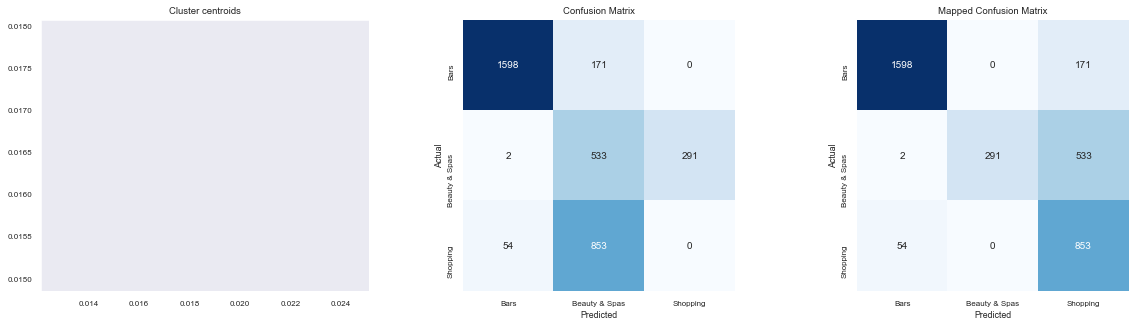

Precision : [0.96614268 1.         0.54784843]
Weighted precision: 0.866
Recall : [0.90333522 0.35230024 0.94046307]
Weighted recall: 0.866
Score : 0.154


In [488]:
labels_c3, centers_c3 = Kmeans_winfo(3, true_labels, document_term_matrix)

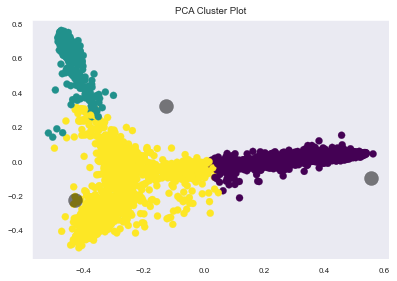

In [489]:
scatter_kmeans(document_term_matrix.todense(), centers_c3, labels_c3)

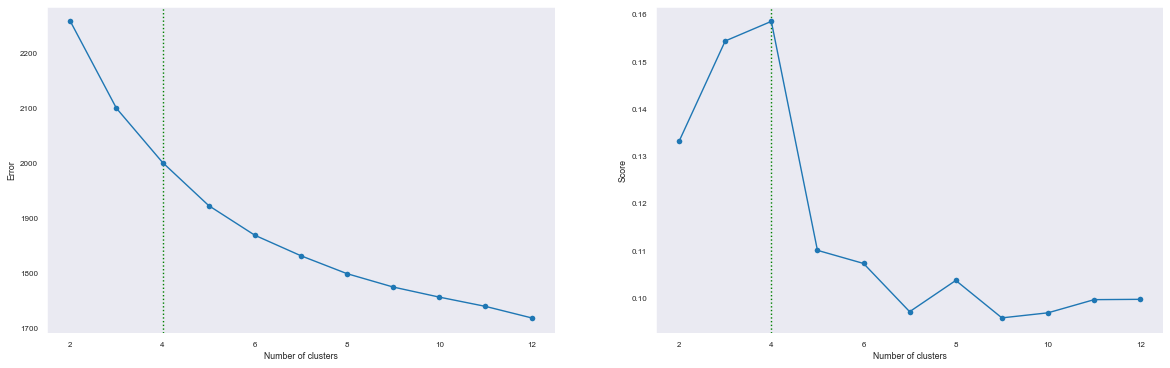

Best number of clusters 4, with silouhette coefficient of 0.1585.


In [490]:
n_clusters = 12
max_score = 0
error = np.zeros(n_clusters+1)
score = np.zeros(n_clusters+1)
for k in range(2,n_clusters+1):     
    start = time.time()
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=25, max_iter=600,  random_state=42)
    preds = kmeans.fit_predict(document_term_matrix)
    error[k] = kmeans.inertia_
    score[k] = silhouette_score(document_term_matrix, preds)
    if (score[k] > max_score):
        f_clasters = k 
        max_score = score[k]
    stop = time.time()
    #print('Clusters {} finished, time {:.2f}s, score {:.2f}'.format(k, stop-start, score[k]))

# Displaying results
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.axvline(x=f_clasters, color='g', linestyle=':')
plt.plot(np.array(range(2,n_clusters+1)), error[2:], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Error')

plt.subplot(1, 2, 2)
plt.axvline(x=f_clasters, color='g', linestyle=':')
plt.plot(np.array(range(2,n_clusters+1)), score[2:], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Score')

plt.show()

print('Best number of clusters {}, with silouhette coefficient of {:.4f}.'.format(f_clasters, max_score))

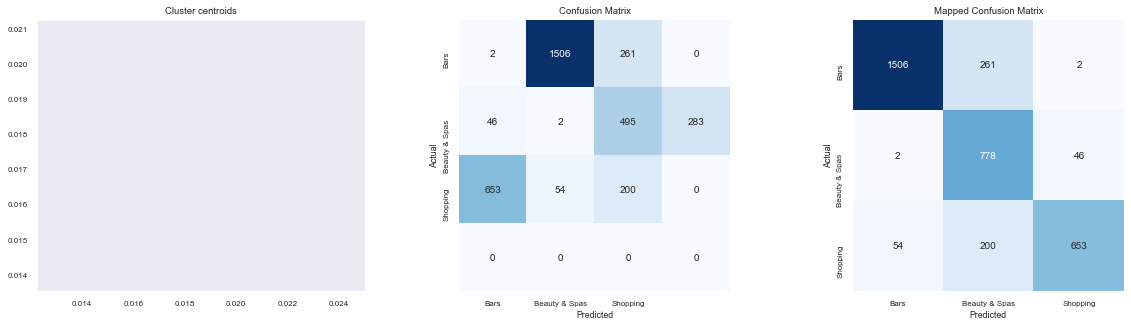

Precision : [0.96414853 0.62792575 0.93152639]
Weighted precision: 0.876
Recall : [0.85132843 0.94188862 0.7199559 ]
Weighted recall: 0.876
Score : 0.140


In [491]:
labels_c4, centers_c4 = Kmeans_winfo(f_clasters, true_labels, document_term_matrix)

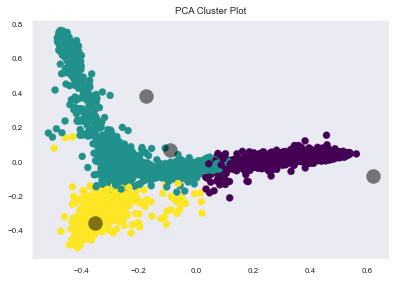

In [492]:
scatter_kmeans(document_term_matrix.todense(), centers_c4, labels_c4)

In [493]:
def display_agglomerative_info(true_labels, predictions, data):
    cfm = confusion_matrix(true_labels, predictions) 

    mapping = list(np.argmax(cfm, axis=0))
    mapped_kmeans_labels = [0 for i in range(len(predictions))]
    for i in range(len(predictions)):
        mapped_kmeans_labels[i] = mapping[predictions[i]]

    score = silhouette_score(data, mapped_kmeans_labels)
    mapped_cfm = confusion_matrix(true_labels, mapped_kmeans_labels)
    precision = precision_score(true_labels, mapped_kmeans_labels, average=None)
    weighted_precision = precision_score(true_labels, mapped_kmeans_labels, average='weighted')
    recall = recall_score(true_labels, mapped_kmeans_labels, average = None)
    weighted_recall =recall_score(true_labels,mapped_kmeans_labels, average = 'weighted')
    
    # Display info
    plt.figure(figsize=(15, 5))
    x_axis_labels = ['Bars', 'Beauty & Spas', 'Shopping']
    plt.title('Mapped Confusion Matrix')
    plt.axis('square')
    sns.heatmap(mapped_cfm, annot=True, cmap='Blues', cbar=False, fmt='d', xticklabels=x_axis_labels)
    plt.show()

    print("Precision : {}".format(precision))
    print("Weighted precision: {:.3f}".format(weighted_precision))
    print("Recall : {}".format(recall))
    print("Weighted recall: {:.3f}".format(weighted_precision))
    print("Score : {:.3f}".format(score))

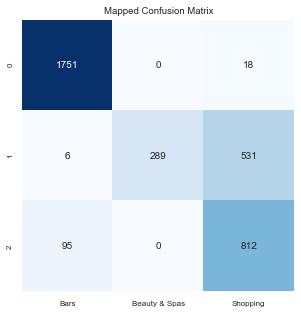

Precision : [0.94546436 1.         0.59662013]
Weighted precision: 0.868
Recall : [0.98982476 0.34987893 0.8952591 ]
Weighted recall: 0.868
Score : 0.155


In [494]:
from sklearn.cluster import AgglomerativeClustering

data_for_agglo = document_term_matrix.todense()
agglomerative = sk_cluster.AgglomerativeClustering(n_clusters=3, linkage='ward')
predictions = agglomerative.fit_predict(data_for_agglo)
display_agglomerative_info(true_labels, predictions, data_for_agglo)

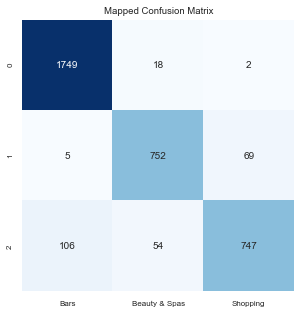

Precision : [0.94032258 0.91262136 0.91320293]
Weighted precision: 0.927
Recall : [0.98869418 0.91041162 0.82359427]
Weighted recall: 0.927
Score : 0.146


In [495]:
agglomerative = sk_cluster.AgglomerativeClustering(n_clusters=3, linkage='complete')
predictions = agglomerative.fit_predict(data_for_agglo)
display_agglomerative_info(true_labels, predictions, data_for_agglo)

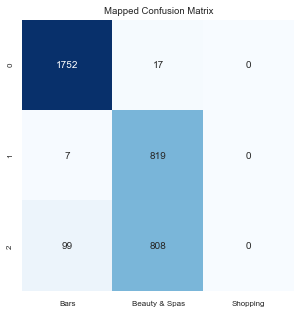

Precision : [0.94294941 0.49817518 0.        ]
Weighted precision: 0.594
Recall : [0.99039005 0.99152542 0.        ]
Weighted recall: 0.594
Score : 0.133


In [496]:
agglomerative = sk_cluster.AgglomerativeClustering(n_clusters=3, linkage='average')
predictions = agglomerative.fit_predict(data_for_agglo)
display_agglomerative_info(true_labels, predictions, data_for_agglo)

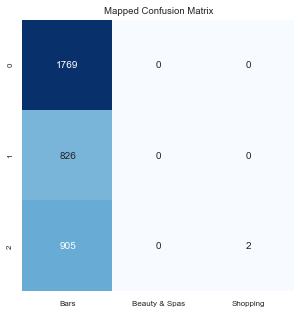

Precision : [0.50542857 0.         1.        ]
Weighted precision: 0.514
Recall : [1.         0.         0.00220507]
Weighted recall: 0.514
Score : 0.057


In [497]:
agglomerative = sk_cluster.AgglomerativeClustering(n_clusters=3, linkage='single')
predictions = agglomerative.fit_predict(data_for_agglo)
display_agglomerative_info(true_labels, predictions, data_for_agglo)

In [498]:
# sampled_buisnesses = np.random.choice(data_for_agglo.shape[0], 10, replace=False)
# sampled_labels  = [value for index, value in enumerate(labels) if index in sampled_buisnesses]
# sampled_data = [value for index, value in enumerate(data_for_agglo) if index in sampled_buisnesses]
# sampled_data = np.array(sampled_data)
# str_sampled_labels = [d[value] for value in sampled_labels]
# str_sampled_labels

In [499]:
def disp_cluster_values(data, labels):
    df = pd.DataFrame(data.todense(), columns=tfidf.get_feature_names())
    df['category'] = labels
    new_df = df.groupby(['category']).mean()
    cluster0 = new_df.iloc[0]
    cluster1 = new_df.iloc[1]
    cluster2 = new_df.iloc[2]
    display(cluster0.sort_values(ascending=False).head(10))
    display(cluster1.sort_values(ascending=False).head(10))
    display(cluster2.sort_values(ascending=False).head())

In [500]:
disp_cluster_values(document_term_matrix, labels_c4)

food          0.357026
menu          0.132856
restaurant    0.128193
ordered       0.121346
chicken       0.104578
beer          0.091054
drinks        0.090084
delicious     0.086789
salad         0.081671
night         0.080514
Name: 0, dtype: float64

hair           0.189746
appointment    0.112810
cut            0.076271
job            0.062921
clean          0.058327
work           0.054430
told           0.052604
amazing        0.048947
asked          0.046168
tea            0.045036
Name: 1, dtype: float64

store        0.391764
shop         0.120843
buy          0.098935
selection    0.096746
items        0.087546
Name: 2, dtype: float64

In [501]:
disp_cluster_values(document_term_matrix, labels_c3)

food          0.342683
menu          0.128617
restaurant    0.121818
ordered       0.116563
chicken       0.098980
drinks        0.096006
beer          0.095250
night         0.084876
delicious     0.084082
order         0.077800
Name: 0, dtype: float64

hair           0.717783
cut            0.268198
appointment    0.118237
colour         0.085130
job            0.060713
wanted         0.060123
style          0.046388
years          0.043530
asked          0.043405
look           0.043151
Name: 1, dtype: float64

store          0.191984
shop           0.075818
appointment    0.073694
customer       0.065441
location       0.056897
Name: 2, dtype: float64